In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#To use double-precision numbers: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html
from jax.config import config
config.update("jax_enable_x64", True)

In [5]:
from patch_gnn.data import load_ghesquire
import pandas as pd
from pyprojroot import here
import pickle as pkl
from patch_gnn.splitting import train_test_split
from jax import random, vmap, nn
from patch_gnn.seqops import one_hot
from patch_gnn.graph import graph_tensors,stack_feature_tensors
from patch_gnn.layers import softmax_on_non_zero,concatenate_node_features,get_norm_attn_matrix
from patch_gnn.models import MPNN, DeepMPNN
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score as evs
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error as mse
import pickle as pkl
from patch_gnn.graph import met_position
import jax.numpy as jnp
import numpy as np

pd.set_option('display.max_rows', 100)

#### The goal for this notebook is to test if using (n_node, n_feat) matrix rather than adjacency matrix + feature matrix could give any results

In [6]:
data = load_ghesquire()

graph_pickle_path = here() / "data/ghesquire_2011/graphs.pkl"
processed_data_path = here() / "data/ghesquire_2011/processed_data.pkl"

with open(graph_pickle_path, "rb") as f:
    graphs = pkl.load(f)

# the cleaned data has everything processed and ready to be used for deep learning
with open(processed_data_path, "rb") as f:
    processed_data = pkl.load(f)
    
key = random.PRNGKey(490)

In [ ]:
# select the graphs that only exist in fitered dataset
# one cannot directly loop through the dict keys, and delete certain ones b/c it is changing 
graphs_to_remove = []
for graph_key in graphs.keys():
    if graph_key not in processed_data["accession-sequence"].tolist():
        print(graph_key)
        graphs_to_remove.append(graph_key)
for graph_key in graphs_to_remove:
    graphs.pop(graph_key)
print(f"the filtered graphs has {len(list(graphs.values()))} graphs")

### Convert inputs to (n_graph, max_num_node, num_features)
forget about sasa and fluc features for a sec

In [10]:
aa_feats = pd.read_csv(here()/"data/amino_acid_properties.csv", index_col=0)
def featurize_amino_acid(n, d, aa_feats: pd.DataFrame) -> pd.Series:
    """
    Featurize a single amino acid.
    
    :param n: Graph node.
    :param d: Graph node attributes.
    :param aa_feats: Dataframe containing amino acid features.
    """
    aa = d["residue_name"]
    feats = pd.Series(aa_feats[aa], name=n)
    return feats

from functools import partial
feature_funcs = [partial(featurize_amino_acid, aa_feats=aa_feats)]

In [11]:
type(graphs)

dict

In [12]:
all_patch_node_feats = stack_feature_tensors(graphs.values(), feature_funcs)
all_patch_node_feats.shape

(362, 19, 61)

#### GAT

In [13]:
n_output_dims = 124

In [14]:
a = random.normal(key=key, shape=(n_output_dims * 2,)) * 0.01
w = random.normal(key=key, shape=(61 , n_output_dims)) * 0.02

In [15]:
params = (w,a)
inputs = all_patch_node_feats

In [16]:
node_projection = jnp.dot(all_patch_node_feats, w) #(373, 19,124)

In [17]:
node_projection[0].shape

(19, 124)

In [18]:
node_by_node_concat = vmap(concatenate_node_features)(node_projection) # do this operation on in all 0th axis of this dataset
node_by_node_concat.shape

(362, 19, 19, 248)

In [19]:
projection = np.dot(node_by_node_concat, a)
atten_after_relu = nn.leaky_relu(projection, negative_slope=0.2)
atten_after_relu.shape

(362, 19, 19)

Kannan says 
>As far as the protein structure is concerned, there is no meaning for the order of amino acids. I think from a structural perspective, it would matter whether the MET residue of interest pays attention to its connected neighbors or not

>as we are primarily interested in the MET residue, we are not interested in how much attention other-none-met residues pays to the rest of non-met residues

This means in the end, we are still interested in the adjacency matrix

### apply modified GAT - only care about how much attention MET pays to other residues
Look at this example's adjacency matrix and feature matrix

In [22]:
adj, feats = graph_tensors(filtered, graphs)
adj.shape, feats.shape

((362, 20, 20, 1), (362, 20, 67))

In [23]:
(filtered.shape)

(362, 18)

#### this suggests Met is connected to all nodes in this patches, which means we can apply softmax directly to the leaky_relu without needing to think about applying masks and then do softmax on non-masked entries

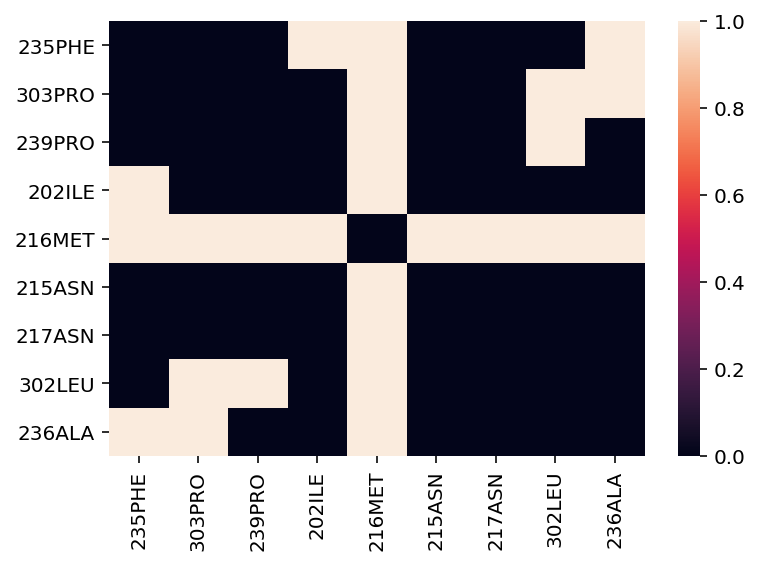

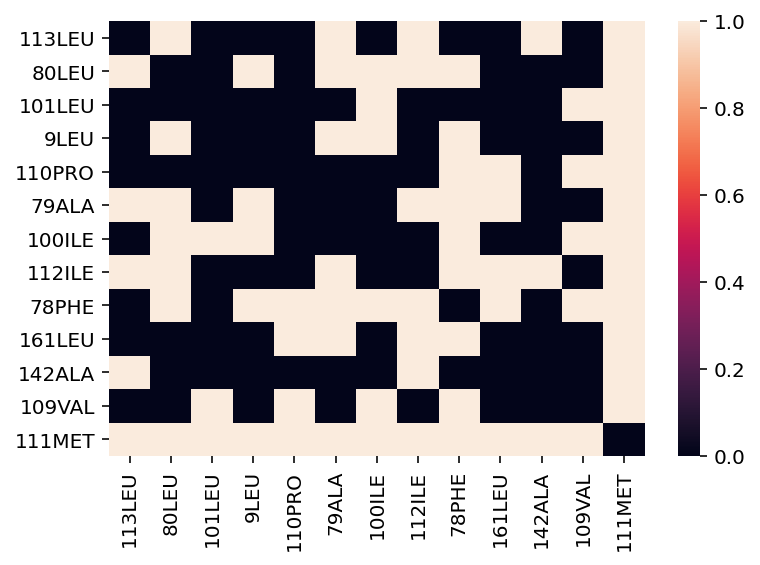

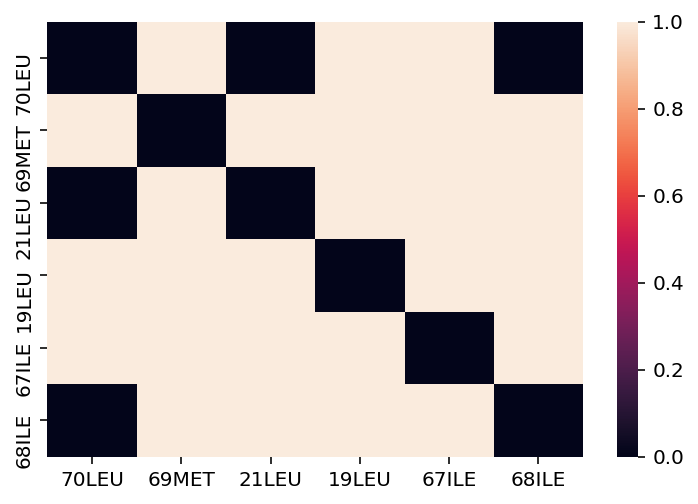

In [24]:
for i in range(3):
    labels = list(graphs[filtered["accession-sequence"].tolist()[i]].nodes())
    num_nodes = len(labels)
    plt.figure()
    sns.heatmap(adj[i,:num_nodes,:num_nodes, :].squeeze(),
                xticklabels = labels, 
                yticklabels= labels)

In [25]:
atten_after_relu.shape

(362, 19, 19)

#### apply softmax norm to attention

In [28]:
matrix = []
for i in range(atten_after_relu.shape[0]):
    #print(i)
    graph = {filtered["accession-sequence"].tolist()[i]: graphs[filtered["accession-sequence"].tolist()[i]]}
    output_i = get_norm_attn_matrix(atten_after_relu[i,:,:], graph)
    matrix.append(output_i)
matrix = jnp.asarray(matrix)
matrix.shape

(362, 19, 19)

In [29]:
norm_attention = []
for graph_num in range(atten_after_relu.shape[0]):
    #print(graph_num)
    norm_attention_i = get_norm_attn_matrix(atten_after_relu[graph_num], {list(graphs.keys())[graph_num]:list(graphs.values())[graph_num]}) 
    norm_attention.append(norm_attention_i)
norm_attention = jnp.asarray(norm_attention)
norm_attention.shape
# below vmap will have no error but is incorrect, b/c each graph will be vmapped to all the rows in atten_after_relu

#norm_attention = vmap(partial(get_norm_attn_matrix_v2, graph = graph))(atten_after_relu) 

(362, 19, 19)

In [ ]:
# (n_max_node, n_feature+1), the +1 is the indicator col to indicate if a node is in the graph or not

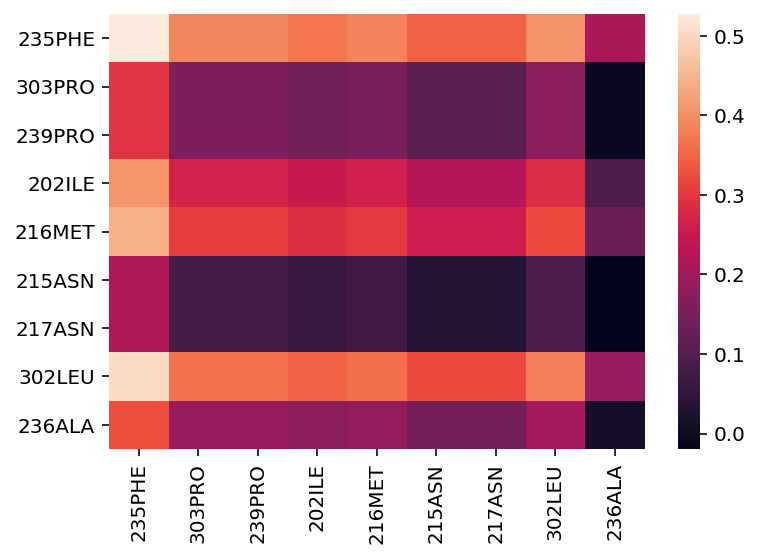

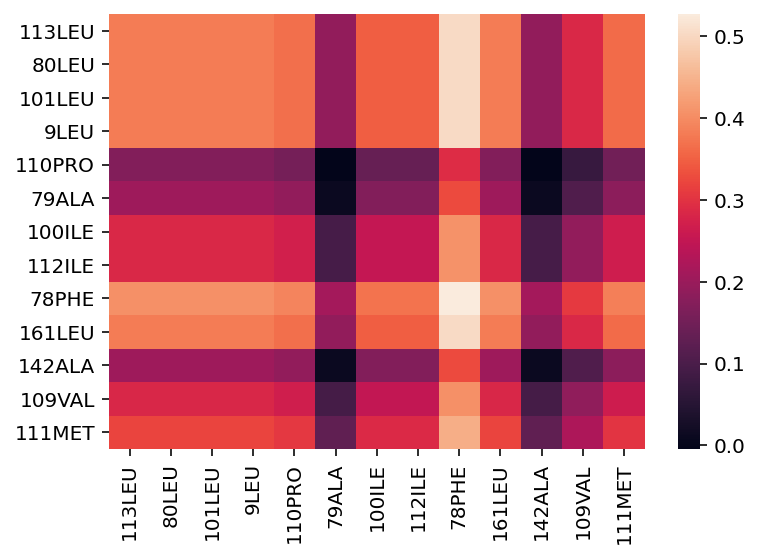

In [30]:
for i in range(2):
    labels = list(graphs.values())[i].nodes()
    num_nodes = len(labels)
    plt.figure()
    sns.heatmap(norm_attention[i,:num_nodes,:num_nodes],
                xticklabels = labels, 
                yticklabels= labels)

#### upgrade the current node_attention

In [37]:
key = random.PRNGKey(12)
k1, k2, k3, k4, k5 = random.split(key, num = 5)
n_patches = 3
n_node = 5
n_features = 13
n_output_dims = 7

w = random.normal(k1, (n_features, n_output_dims))  
a = random.normal(k2, (n_output_dims*2, )) 
nfa = random.normal(k3, (n_features, ))
adjacency_matrix = random.normal(k4, (n_node,n_node ))
node_embeddings = random.normal(k5, (n_node,n_features ))
node_feat_attn = vmap(partial(jnp.multiply, jnp.abs(nfa)))(node_embeddings)
node_projection = jnp.dot(node_feat_attn, w)
node_by_node_concat = concatenate_node_features(node_projection)
projection = np.dot(node_by_node_concat, a)
atten_leaky_relu = nn.leaky_relu(projection, negative_slope=0.1)
atten_leaky_relu = np.squeeze(atten_leaky_relu)
attention = atten_leaky_relu * np.squeeze(adjacency_matrix)
attention.shape

(5, 5)

In [186]:
attention = jnp.asarray([[0,4,5,7,2],
                         [3,4,5,0,2],
                         [4,0,0,8,6],
                         [5,2,4,0,5],
                         [6,-4,0,0,0]])

In [187]:
adj = jnp.asarray([[0,1,0,1,1],
                   [1,1,1,0,1],
                   [0,0,0,1,1],
                   [1,1,1,0,1],
                   [1,1,1,0,0]])

In [216]:
np_adj = np.array(adj)
np_adj = np_adj.astype("float")
np_adj[np_adj == 0] = np.nan
np_adj

array([[nan,  1., nan,  1.,  1.],
       [ 1.,  1.,  1., nan,  1.],
       [nan, nan, nan,  1.,  1.],
       [ 1.,  1.,  1., nan,  1.],
       [ 1.,  1.,  1., nan, nan]])

In [217]:
mask_attention = attention * np_adj
mask_attention

DeviceArray([[nan,  4., nan,  7.,  2.],
             [ 3.,  4.,  5., nan,  2.],
             [nan, nan, nan,  8.,  6.],
             [ 5.,  2.,  4., nan,  5.],
             [ 6., -4.,  0., nan, nan]], dtype=float64)

In [226]:
def softmax_non_zero(x):
    return jnp.where(jnp.invert(jnp.isnan(x)), print(x +1), x)
    #return jnp.where((jnp.isnan(x)), nn.softmax(x),x)

In [242]:
[ ~np.isnan(i) for i in jnp.asarray([jnp.nan,  4., jnp.nan,  7.,  2.]) ] * np.array([jnp.nan,  4., jnp.nan,  7.,  2.])

array([nan,  4., nan,  7.,  2.])

In [248]:
[np.array(x)[y] for x, y in zip(jnp.asarray([jnp.nan,  4., jnp.nan,  7.,  2.]), 
                                            jnp.asarray([ ~np.isnan(i) for i in jnp.asarray([jnp.nan,  4., jnp.nan,  7.,  2.]) ]))]

[array([], dtype=float64),
 array([4.]),
 array([], dtype=float64),
 array([7.]),
 array([2.])]

In [227]:
# test without vmap
for i in range(len(mask_attention)):
    print(softmax_non_zero(mask_attention[i]) *(adj[i]))

[nan  5. nan  8.  3.]


ValueError: Either both or neither of the x and y arguments should be provided to jax.numpy.where, got None and Traced<ShapedArray(float64[5])>with<DynamicJaxprTrace(level=0/1)>.

In [198]:
# test with vmap
vmap(softmax_non_zero)(mask_attention) *(adj)

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(float64[5])>with<BatchTrace(level=1/0)>
  with val = DeviceArray([[nan,  4., nan,  7.,  2.],
                          [ 3.,  4.,  5., nan,  2.],
                          [nan, nan, nan,  8.,  6.],
                          [ 5.,  2.,  4., nan,  5.],
                          [ 6., -4.,  0., nan, nan]], dtype=float64)
       batch_dim = 0 (https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError)

In [121]:
from patch_gnn.layers import GraphAttention_v2
from jax.experimental import stax

init_fun, apply_fun = GraphAttention_v2(n_output_dims=128)

output_shape, params = init_fun(key, input_shape=(20, 61, 1))

out = vmap(partial(apply_fun, params))((all_patch_node_feats,graphs))
out.shape

AttributeError: 'Graph' object has no attribute 'shape'

Notes to self:|

1. Input shape is always `(-1, n_node_feats)`.
2. Always vmap the `apply_fun`!!!!!

## Custom models

In [ ]:
from patch_gnn.layers import GraphSummation
model_init_fun, model_apply_fun = stax.serial(
    GraphAttention(n_output_dims=128),
    GraphSummation(),
    stax.Dense(128),
    stax.Relu,
    stax.Dense(1),
)

In [ ]:
output_shape, params = model_init_fun(key, input_shape=(20, 67, 1))
output = vmap(partial(model_apply_fun, params))(train_graph)

In [ ]:
output.shape

In [ ]:
from patch_gnn.models import DeepGAT

In [ ]:
model = DeepGAT(node_feature_shape=(20, 67), num_adjacency=1, num_training_steps=500)

In [ ]:
from patch_gnn.layers import concatenate_node_features, node_attention

attentions, output = vmap(partial(node_attention, model.params[0]))(train_graph)
sns.heatmap(attentions[0])

In [ ]:
model.fit(train_graph, train_target)

In [ ]:
checkpoint = -1
preds = model.predict(test_graph, checkpoint=checkpoint)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.scatter(test_target.squeeze(), preds.squeeze())
plt.plot([-5, 0], [-5, 0])

In [ ]:
plt.plot(model.loss_history)
plt.yscale("log")

In [ ]:
train_preds = model.predict(train_graph, checkpoint=checkpoint)

In [ ]:
plt.scatter(train_target.squeeze(), train_preds.squeeze())
plt.plot([-5, 0], [-5, 0])

In [ ]:
from sklearn.metrics import explained_variance_score as evs, r2_score as r2

In [ ]:
from tqdm.auto import tqdm
from jax import jit
def learning_curves(model, data, score_func, *, interval: int=20):
    X, y = data
    scores = []
    for i in tqdm(range(len(model.loss_history))[::interval]):
        preds = model.predict(X, checkpoint=i)
        score = score_func(y.squeeze(), preds.squeeze())
        scores.append(score)
    return scores

In [ ]:
interval = 5
train_score = learning_curves(model, (train_graph, train_target), r2, interval=interval)
test_score = learning_curves(model, (test_graph, test_target), r2, interval=interval)

## Learning curve with epochs

In [ ]:
plt.plot(train_score)
plt.plot(test_score)
plt.xlabel(f"Training steps divided by {interval}")
plt.ylabel("score")
plt.title("r2")


In [ ]:
r2(train_target.squeeze(), train_preds.squeeze())

In [ ]:
r2(test_target.squeeze(), preds.squeeze())

## Explore what's learned by GATs

Per-graph, what is the attention matrix like.

In [ ]:
import jax.numpy as np
from patch_gnn.layers import concatenate_node_features, node_attention
from jax import nn

In [ ]:
train_df.query("ox_fwd_logit > -0.5")

In [ ]:
idx = list(train_df.index).index(2297)

In [ ]:
row = train_df.iloc[idx]
row["ox_fwd_logit"]

In [ ]:
g_key = row["accession-sequence"]
g_key

In [ ]:
g = graphs[g_key]
g.nodes()

In [ ]:
g.nodes(data=True)

In [ ]:
import pandas as pd

aa_props = pd.read_csv(here() / "data/amino_acid_properties.csv", index_col=0)

In [ ]:
index = list(aa_props.index)
index.extend(["Phob", "Phil", "SASA", "N"])

In [ ]:
pd.Series(dict(zip(index, np.abs(model.params[0][2])))).sort_values().to_dict()

In [ ]:
import seaborn as sns
attentions, output = vmap(partial(node_attention, model.params[0]))(train_graph)
ax = sns.heatmap(attentions[idx][0:len(g.nodes()), 0:len(g.nodes())], cmap="viridis")
ax.set_xticklabels(list(g.nodes()), rotation = 90)
ax.set_yticklabels(list(g.nodes()), rotation = 0)
attentions.shape

The vertical numbers are not all identical. Keep that in mind.

In [ ]:
import networkx as nx
nx.draw(g, with_labels=True)

# GRAVEYARD

In [ ]:
from patch_gnn.layers import normalize_if_nonzero
from jax import grad

In [ ]:
normalize_if_nonzero(p_vect=np.zeros(3))

In [ ]:
a = np.array([0.1, 0.5, 0.0])
normalize_if_nonzero(p_vect=a)

In [ ]:
def f(p):
    p = normalize_if_nonzero(p)
    return np.sum(p)

In [ ]:
f(np.)

In [ ]:
df = grad(f)

In [ ]:
df(np.zeros(3)),  df(a)